In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

##### Se crean los paths al directorio data, donde se encuentran las imágenes

In [2]:
TRAIN_PATH = "C:\\Users\\inilo\\OneDrive\\Escritorio\\ClasificadorCNN_Rocas\\src\\data"
TEST_PATH = "C:\\Users\\inilo\\OneDrive\\Escritorio\\ClasificadorCNN_Rocas\\src\\data"
VALID_PATH = "C:\\Users\\inilo\\OneDrive\\Escritorio\\ClasificadorCNN_Rocas\\src\\data"

##### Se dividen los directorios en train, test y valid. Se definen tanto el tamaño de los batchs como el tamaño de las imágenes que se analizarán

##### En este caso se ha escogido 224 x 224 ya que es la resolución con la que mejor trabaja el modelo ResNet50

In [3]:
train_dir = os.path.join(TRAIN_PATH, 'train')
validation_dir = os.path.join(VALID_PATH, 'valid')
test_dir = os.path.join(TEST_PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

##### Se cargan las imágenes de test en una variable aparte donde se extraerán las clases y las imágenes sin procesar para que conserven el color original

Más adelanete se llevarán a cabo procesos que cambian la estructura de la imagen, con lo que viene bien tener una variable con las imágenes sin alterar y sus clases asociadas. Estas imágenes inalteradas nos servirán después para ver los resultados de las predicciones junto a los gráficos de barra de la confianza de las predicciones.

Se declara test_dataset_raw y se le pasa el directorio de test, se le indica que no mezcle las imágenes, además de especificarle los tamaños de imagen y batch definidos anteriormente

In [ ]:
test_dataset_raw = tf.keras.utils.image_dataset_from_directory( # El distintivo raw distingue esta variable que guarda las imágenes y las etiquetas de lss demás variables que se usarán en el entrenamiento
    test_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 274 files belonging to 6 classes.


Se declara la variable que recoge los nombres de cada tipo de roc en class_names. Esto servirá más adelante para las representaciones gráficas como la matriz de confusión o los histogramas de confianza de predicción

In [5]:
class_names = test_dataset_raw.class_names
print("Clases:", class_names)

Clases: ['Conglomerate', 'Dolomitic Limestone', 'Limestone', 'Sandstone', 'Shale_(Mudstone)', 'tezontle']


In [ ]:
# Extraer X_test e y_test sin preprocesar
X_test_raw = []
y_test = []
for images, labels in test_dataset_raw:
    X_test_raw.extend(images.numpy())
    y_test.extend(labels.numpy())
X_test_raw = np.array(X_test_raw)
y_test = np.array(y_test)

##### A continuación se define AUTOTUNE

En TensorFlow, AUTOTUNE se usa para optimizar el rendimiento del pipeline de entrada de datos, especialmente en la carga y procesamiento de imágenes desde el disco. Ayuda a reducir el tiempo de entrenamiento y aprovecha mejor los recursos del sistema.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

Se define la función preprocess que procesará las imágenes de cada conjunto

In [7]:
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

Con from_directory se definen las variables que almecenarán las fotos para luego procesarlas. Así como en test_dataset_raw, se definen los directorios de train, test y valid y se determina si se desea mezclar las imágenes (en el caso del entrenamiento es recomendable para evitar sesgos)

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5667 files belonging to 6 classes.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 539 files belonging to 6 classes.


In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 274 files belonging to 6 classes.


Ahora viene el procesamiento, en este caso se realiza un .map() y .prefecth() a cada una de las variables que contienen las imágenes de cada conjunto. Map aplica transformaciones a las imágenes (como preprocess) en paralelo usando tantos núcleos como sea eficiente gracias a AUTOTUNE. Prefetch carga por adelantado lotes de imágenes mientras el modelo está entrenando el lote actual, evitando cuallos de botella por lectura de disco.

In [11]:
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Comenzamos la construcción del modelo

1. Declaramos el modelo ResNet50, un modelo de Transfer Learning de 50 capas diseñada para clasificación de imágenes.
Se indica que el shape de la imagen como 224 x 224 y se añaden los 3 canales de colores.
Con 'include_top = False' se quitan las últimas capas de clasificación de ImageNet al tener un número diferente de clases
Se especifica que se utilizarán los pesos de ImageNet con 'weights'.

2. Al principio las capas de ResNet no se entrenarán, únicamente lo harán las nuevas capas añadidas. Esto lo podemos indicar declarando 'traibnable' como False.

3. Se contruyen las capas del modelo:
GlobalAveragePooling2D aplana la salida del modelo base haciendo un promedio por canal. Esto reduce la dimensionalidad y evita el uso de muchas neuronas.
A continuación hay una capa de 128 neuronas ideal para casos de Deep Learning y que detectan patrones personalizados.
El Dropout apaga aleatoriamente en este caso el 30% de las neuronas en cada batch durante la etapa de train para así mejorar la generalización
La última capa debe coincidir con el número de clases (en este caso son 6 tipos de roca). Softmax asegura que la suma de probabilidades sea 1.

In [13]:
base_model = ResNet50(input_shape=IMG_SIZE + (3,),
                      include_top=False,
                      weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 clases
])

#### Compilación del modelo

In [1]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

NameError: name 'model' is not defined

#### Declaramos el EarlyStopping

1. En este caso se monitorea la pérdida del conjunto de validación durante el entrenamiento (val_loss).
Se esperan hasta 15 épocas consecutivas sin mejora antes de detener el train. Se interrumpirá el entrenamiento si no se observa dicha mejora en el entrenamiento.
Con 'restore_best_weights = True' se recuperan los pesos del modelo correspondientes a la época donde se obtuvo el mejor rendimiento (menos val_los). Esto ayuda a no usar posteriormente datos sobreentrenados.

2. Se definen un máximo de 50 épocas.

3. Hacemos el fit del modelo con conjunto de train y usando el conjunto de validación para evaluar el desempeño tras cada época.

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
)

Epoch 1/50
178/178 [==============================] - 279s 2s/step - loss: 1.0000 - accuracy: 0.6333 - val_loss: 0.8369 - val_accuracy: 0.7050
Epoch 2/50
178/178 [==============================] - 275s 2s/step - loss: 0.5468 - accuracy: 0.8025 - val_loss: 0.7265 - val_accuracy: 0.7551
Epoch 3/50
178/178 [==============================] - 323s 2s/step - loss: 0.3676 - accuracy: 0.8742 - val_loss: 0.6101 - val_accuracy: 0.7978
Epoch 4/50
178/178 [==============================] - 354s 2s/step - loss: 0.2721 - accuracy: 0.9070 - val_loss: 0.6019 - val_accuracy: 0.8256
Epoch 5/50
178/178 [==============================] - 205s 1s/step - loss: 0.2062 - accuracy: 0.9314 - val_loss: 0.6051 - val_accuracy: 0.8219
Epoch 6/50
178/178 [==============================] - 283s 2s/step - loss: 0.1404 - accuracy: 0.9562 - val_loss: 0.5758 - val_accuracy: 0.8349
Epoch 7/50
178/178 [==============================] - 205s 1s/step - loss: 0.1283 - accuracy: 0.9605 - val_loss: 0.5897 - val_accuracy: 0.8460

#### Fine-tuning

1. Una vez entrenado el clasificador, se desbloquean las capas profundas del modelo preentrenado ResNet50 para ajustar los pesos con nuestro dataset.

2. Se define el límite de 'congelamiento' de capas a 120 (las capas desde la 120 a la capa final serán ajustadas). Esto ayuda a evitar el overfitting.

3. Se vuelve a recompliar el modelo al haber modificado las capas entrenables. Se usa un learning rate mucho más bajo para que los pesos no se alteren bruscamente.

4. Se añaden 10 épocas más después del entrenamiento inicial.

5. Se retoma el entrea¡namiento donde acabo el fit anterior gracias al parámetro initial_epoch.

In [16]:
base_model.trainable = True

fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = EPOCHS + 10

history_finetune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping]
)

Epoch 27/60
178/178 [==============================] - 649s 4s/step - loss: 0.5210 - accuracy: 0.8355 - val_loss: 0.6977 - val_accuracy: 0.8330
Epoch 28/60
178/178 [==============================] - 717s 4s/step - loss: 0.1535 - accuracy: 0.9472 - val_loss: 0.6585 - val_accuracy: 0.8571
Epoch 29/60
178/178 [==============================] - 592s 3s/step - loss: 0.0929 - accuracy: 0.9711 - val_loss: 0.6598 - val_accuracy: 0.8590
Epoch 30/60
178/178 [==============================] - 608s 3s/step - loss: 0.0634 - accuracy: 0.9811 - val_loss: 0.6704 - val_accuracy: 0.8534
Epoch 31/60
178/178 [==============================] - 609s 3s/step - loss: 0.0491 - accuracy: 0.9848 - val_loss: 0.6854 - val_accuracy: 0.8609
Epoch 32/60
178/178 [==============================] - 620s 3s/step - loss: 0.0340 - accuracy: 0.9917 - val_loss: 0.6861 - val_accuracy: 0.8609
Epoch 33/60
178/178 [==============================] - 650s 4s/step - loss: 0.0334 - accuracy: 0.9914 - val_loss: 0.6921 - val_accuracy:

Ploteamos el history para ver la evolución de las funciones de pérdida y la variación de la precisión al ir aumentando las épocas. 

<Axes: >

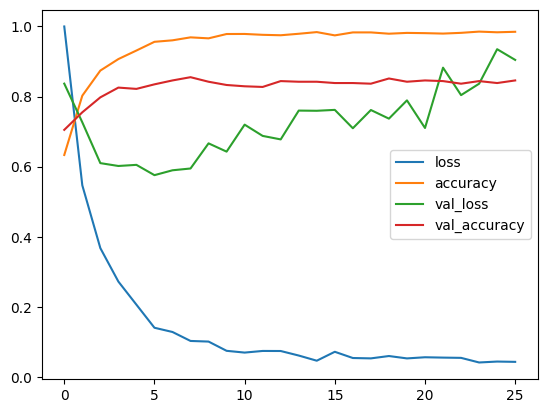

In [17]:
pd.DataFrame(history.history).plot()

Evaluamos el rendimiento del modelo sobre el conunto de test. Con esto obtenemos dos valores: test_loss indica lo bien que se ajusta un modelo a los datos de test, mientras que test_accuracy indica el % de aciertos sobre las imágenes en el conjunto de test.

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Precisión en test: {test_accuracy * 100:.2f}%")

9/9 [==============================] - 11s 1s/step - loss: 0.6158 - accuracy: 0.8796
Precisión en test: 87.96%


Creamos una matriz de confusión para ver concretamente qué clases son las mejores predichas y cuáles son las que el modelo tiene más dificultades para clasificar. En nuestro caso, las calizas dolomíticas son las que poseen más falsos positivos y las calizas son las rocas que mejor clasifica nuestro modelo.

1/1 [==============================] - 1s 1s/step


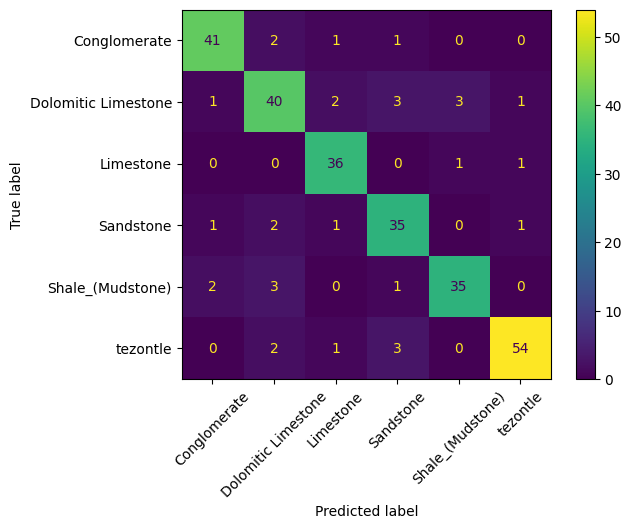

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)

#### Hacemos las predicciones con los datos de test

Predecimos para la probabilidad de que cada imagen pertenezca a cada clase. Con ayuda de argmax, podemos obtener la clase más probable para cada imagen.

In [20]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

9/9 [==============================] - 10s 1s/step


Este conjunto de funciones permite visualizar el conjunto de imágenes de test y junto a cada imagen se representa un plot de los grados de confianza para cada clase. La clase correcta vendrá representada en azul y, en caso de que el mayor nivel de confianza no coincida con la etiqueta real de los fotografía, se pintará la barra del gráfico en rojo.

In [21]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.astype("uint8"))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Visualizamos una serie de imágenes del test con sus predicciones correspondientes. Podemos ver que la mayoría están bien predichas pues la barra azul es la que mayor cinfianza tiene pero otras imágenes no han sido bien clasificadas.

In [ ]:
num_rows = 4
num_cols = 2
num_images = num_rows*num_cols
random_indices = np.random.choice(len(X_test_raw), num_images, replace=False)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(18, 15))
for i, idx in enumerate(random_indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(idx, y_pred_probs[idx], y_test, X_test_raw)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(idx, y_pred_probs[idx], y_test)
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

#### Histograma de confianzas

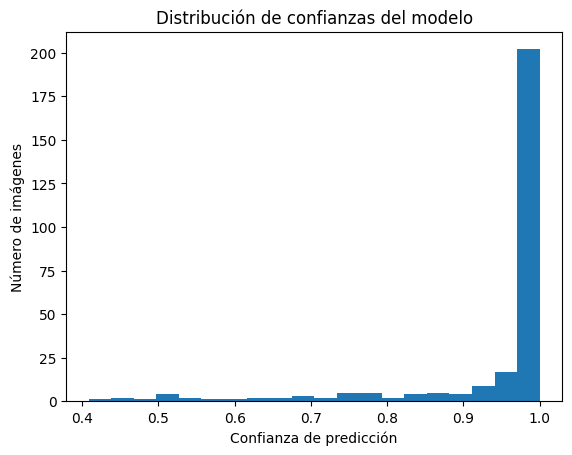

In [24]:
confidences = np.max(y_pred_probs, axis=1)

plt.hist(confidences, bins=20)
plt.xlabel('Confianza de predicción')
plt.ylabel('Número de imágenes')
plt.title('Distribución de confianzas del modelo')
plt.show()

Podemos calcular el número de errores donde el modelo estaba practicamente seguro que había clasificado bien la imagen

In [25]:
wrong_confident = [(i, conf) for i, (conf, true, pred) in enumerate(zip(confidences, y_test, y_pred)) if true != pred and conf > 0.9]

print(f"Número de errores con confianza > 90%: {len(wrong_confident)}")

Número de errores con confianza > 90%: 15
